# GitOps Flow with MLRun

In [2]:
# !pip install s3fs

## Setup Project

In [4]:
import os
import json

from src import create_and_set_project
from config import AppConfig
from dotenv import load_dotenv

load_dotenv("secrets.env")

config = AppConfig()

project = create_and_set_project(
    name=config.project_name,
    source=config.archive_source,
    secrets_file=config.secrets_file,
    artifact_path=config.artifact_path,
    default_image="nschenone/mlrun-cicd:1.5.0",
    force_build=True
)

> 2024-05-14 21:38:33,251 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...


Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead
Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead


## Run Training Pipeline

In [5]:
train_config = config.get_workflow_config(workflow_name="train")

In [6]:
project.notifiers.add_notification(notification_type="slack", params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

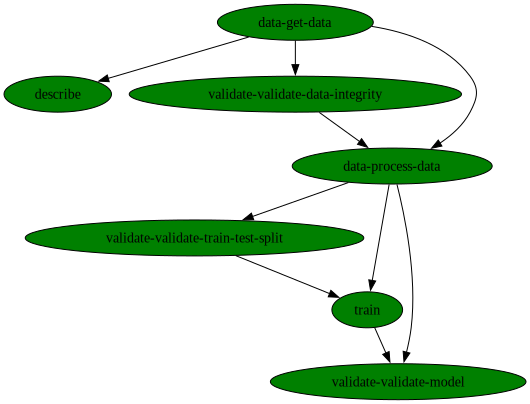

uid,start,state,name,parameters,results
...39752ff0,May 14 21:43:04,completed,validate-validate-model,model_path=store://artifacts/cicd-flow/model:ed8423cc-69e1-4929-a749-44339e2535bblabel_column=targetallow_validation_failure=True,passed_suite=False
...e4f5f8a1,May 14 21:42:21,completed,train,label_column=target,best_iteration=1accuracy=0.8620689655172413f1_score=0.8571428571428571precision_score=0.75recall_score=1.0
...5f106dd4,May 14 21:41:50,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...e01b60e8,May 14 21:41:25,completed,data-process-data,"label_column=targettest_size=0.1ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...a9d80b7c,May 14 21:40:27,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...d3bf5955,May 14 21:40:27,completed,describe,label_column=target,
...6c7fc61d,May 14 21:39:55,completed,data-get-data,,


In [7]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [19]:
deploy_config = config.get_workflow_config(workflow_name="deploy")

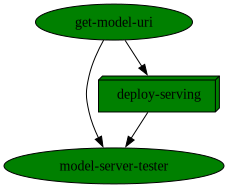

uid,start,state,name,parameters,results
...dec0eee5,May 14 21:56:05,completed,model-server-tester,addr=http://cicd-flow-serving-cicd-flow.default-tenant.app.cst-354.iguazio-cd2.com/label_column=targetmodel=model,total_tests=20errors=0match=12avg_latency=82711min_latency=80745max_latency=88033
...0863e8bb,May 14 21:53:50,completed,get-model-uri,model_name=modelmodel_tag=challenger,model_uri=store://models/cicd-flow/model#0:4a44d0202c4ca6ac2f756b15063a9ea257306b42test_set_uri=s3://iguazio-demo/projects/cicd-flow/artifacts/a1e2cfb9-cded-4f25-9dcf-e673fb6230fa/train/1/test_set.parquet


In [16]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

### Invoke Model

In [21]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


In [22]:
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

> 2024-05-14 22:02:22,414 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': 'cdc3c93e-1ab2-43e7-8ca8-1f404bb26681',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [7]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(10)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )
    print(resp)

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/10 [00:00<?, ?it/s]

{'id': 'f9566126-9cad-4f15-ac43-70a1742a3330', 'model_name': 'model', 'outputs': [1.0]}
{'id': '66731fa0-3676-4efd-bd2b-9f9544cdde2f', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'f7bfe5b6-859a-4b59-80ec-7ab826f03fa2', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'b2c52fd1-b889-4010-baf4-dd180ced0a07', 'model_name': 'model', 'outputs': [0.0]}
{'id': '96f9d387-85fb-4792-9322-764491bab447', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'f16aa6ef-aa0c-4d20-b5a1-9f602a5abf2e', 'model_name': 'model', 'outputs': [1.0]}
{'id': '7ddb4898-bcf2-4e9e-ab99-3dc51333e512', 'model_name': 'model', 'outputs': [0.0]}
{'id': '05c702df-7bd4-4a41-957c-437daee7a4cb', 'model_name': 'model', 'outputs': [1.0]}
{'id': '4fcba794-e8c5-420b-bbe6-cff6cbb9abf7', 'model_name': 'model', 'outputs': [0.0]}
{'id': '53a3a3d9-35fd-4666-a7fa-a4f82834f00b', 'model_name': 'model', 'outputs': [1.0]}
